In [8]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir input

In [10]:
!mv "/content/drive/MyDrive/COVID-19" "/content/input"

In [11]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
TrianImage="/content/input/COVID-19/Train/" #/content/input/COVID-19/Train
TestImage="/content/input/COVID-19/Test/"
ValImage="/content/input/COVID-19/Validation"
Normalimages = os.listdir(TrianImage + "/Normal")
Pneumonaimages = os.listdir(TrianImage + "/Pneumonia")
COVID19images = os.listdir(TrianImage + "/Covid")

In [15]:
print(len(Normalimages), len(Pneumonaimages), len(COVID19images))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages) + len(COVID19images)
print(NUM_TRAINING_IMAGES)

1142 1051 1040
3233


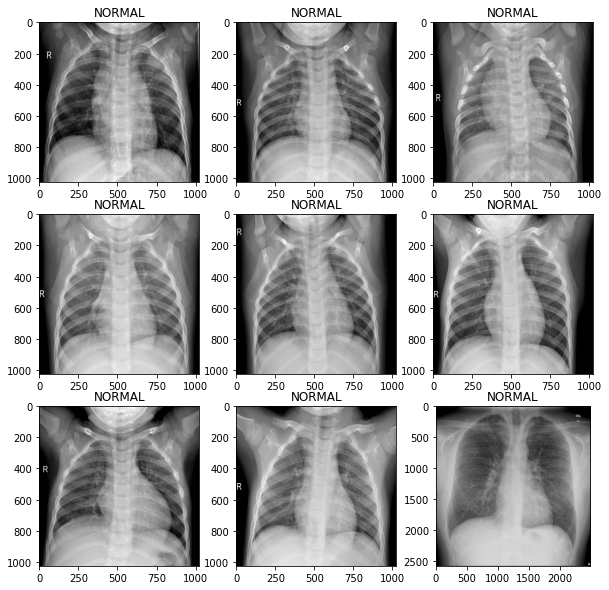

In [18]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Normal",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

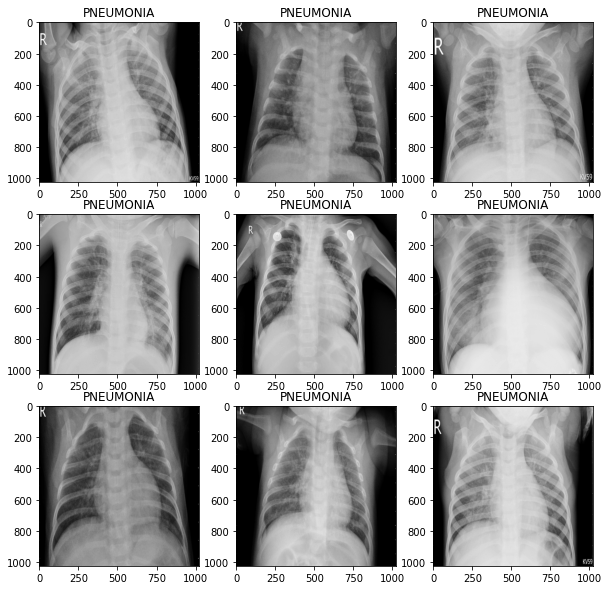

In [19]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Pneumonia",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

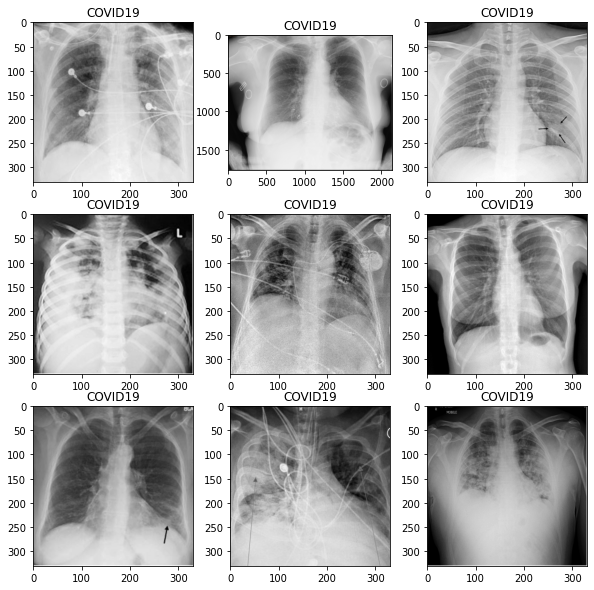

In [20]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/Covid",COVID19images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

In [22]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

image_size = 224 
BATCH_SIZE = 64
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/content/input/COVID-19'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/Train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/Test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

validation_set = validation_datagen.flow_from_directory(data_path + '/Validation',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 3233 images belonging to 3 classes.
Found 1012 images belonging to 3 classes.
Found 802 images belonging to 3 classes.


In [23]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("validation batch ", validation_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (64, 224, 224, 3)
test batch  (64, 224, 224, 3)
validation batch  (64, 224, 224, 3)
sample train label 
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [24]:
training_set.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

In [25]:
testing_set.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

In [26]:
validation_set.class_indices

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

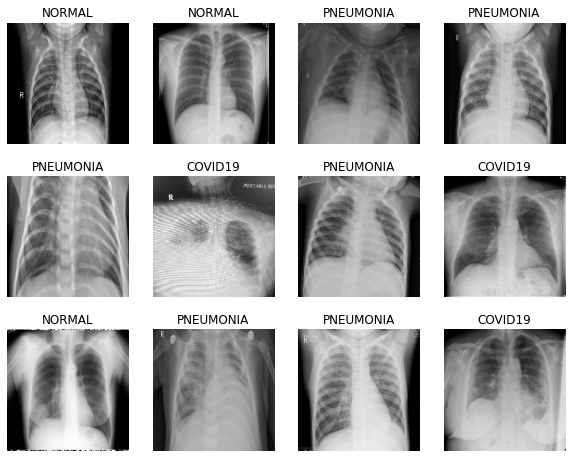

In [27]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

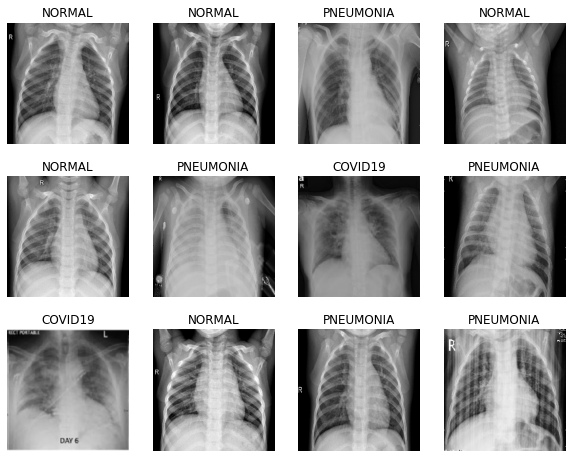

In [28]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = validation_set.__getitem__(1)[0] 
sample_label = validation_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [29]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 51kB 4.3MB/s 


In [30]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [31]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [32]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [33]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [36]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_delta=0.001, patience=5, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1)

In [37]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0980769230769232, 1: 1.0, 2: 1.0865842055185537}

In [38]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape) 

82526208/82524592 [==============================] - 2s 0us/step
(None, 224, 224, 3)
268320768/268317848 [==============================] - 5s 0us/step
(None, 600, 600, 3)
553467904/553467096 [==============================] - 4s 0us/step
(None, 224, 224, 3)


# Pretrained densenet

In [39]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [41]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=validation_set, callbacks=[lr_reduce, es_callback], epochs=40) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
51/51 [==============================] - 155s 2s/step - loss: 1.4370 - accuracy: 0.5955 - val_loss: 0.5245 - val_accuracy: 0.8890
Epoch 2/40
51/51 [==============================] - 100s 2s/step - loss: 0.6479 - accuracy: 0.7891 - val_loss: 0.5393 - val_accuracy: 0.9090
Epoch 3/40
51/51 [==============================] - 99s 2s/step - loss: 0.6491 - accuracy: 0.7751 - val_loss: 0.4734 - val_accuracy: 0.9052
Epoch 4/40
51/51 [==============================] - 99s 2s/step - loss: 0.6058 - accuracy: 0.8316 - val_loss: 0.4676 - val_accuracy: 0.9214
Epoch 5/40
51/51 [==============================] - 99s 2s/step - loss: 0.6123 - accuracy: 0.8359 - val_loss: 0.4508 - val_accuracy: 0.9401
Epoch 6/40
51/51 [==============================] - 99s 2s/step - loss: 0.5776 - accuracy: 0.8605 - val_loss: 0.4163 - val_accuracy: 0.9426
Epoch 7/40
51/51 [==============================] - 99s 2s/step - loss: 0.5743 - accuracy: 0.8671 - val_loss: 0.3948 - val_accuracy: 0.9539
Epoch 8/40
51/51 [

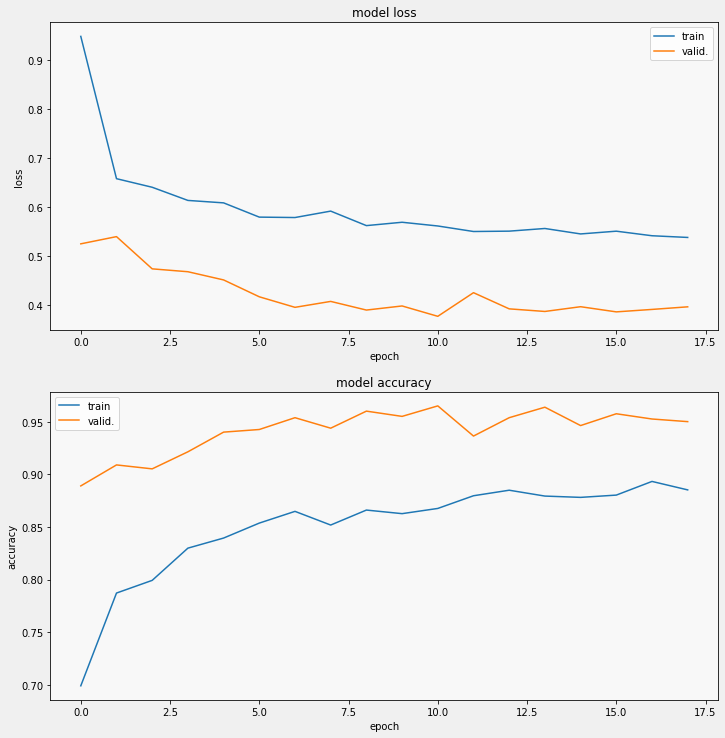

In [42]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)

In [43]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

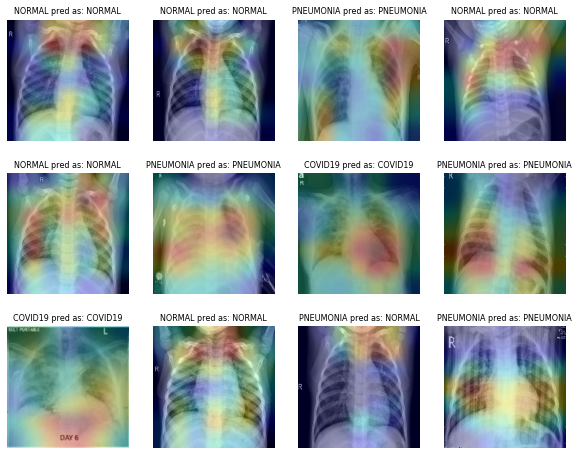

In [48]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [49]:
model_densenet.save("model_densenet_30_09596.h5")

# Pretrained efnet

In [51]:
# https://github.com/keras-team/keras/issues/9064
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_19[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
___________________________________________________________________________________________

In [52]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=validation_set, callbacks=[lr_reduce, es_callback], epochs=40)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
51/51 [==============================] - 134s 2s/step - loss: 1.8091 - accuracy: 0.4063 - val_loss: 0.9500 - val_accuracy: 0.5324
Epoch 2/40
51/51 [==============================] - 109s 2s/step - loss: 0.9455 - accuracy: 0.5815 - val_loss: 0.7784 - val_accuracy: 0.6571
Epoch 3/40
51/51 [==============================] - 109s 2s/step - loss: 0.8583 - accuracy: 0.6504 - val_loss: 0.7632 - val_accuracy: 0.6870
Epoch 4/40
51/51 [==============================] - 108s 2s/step - loss: 0.8293 - accuracy: 0.6579 - val_loss: 0.7281 - val_accuracy: 0.6958
Epoch 5/40
51/51 [==============================] - 109s 2s/step - loss: 0.7859 - accuracy: 0.7046 - val_loss: 0.6571 - val_accuracy: 0.8055
Epoch 6/40
51/51 [==============================] - 109s 2s/step - loss: 0.7747 - accuracy: 0.7178 - val_loss: 0.6233 - val_accuracy: 0.8329
Epoch 7/40
51/51 [==============================] - 108s 2s/step - loss: 0.7883 - accuracy: 0.6994 - val_loss: 0.6363 - val_accuracy: 0.8005
Epoch 8/40
51

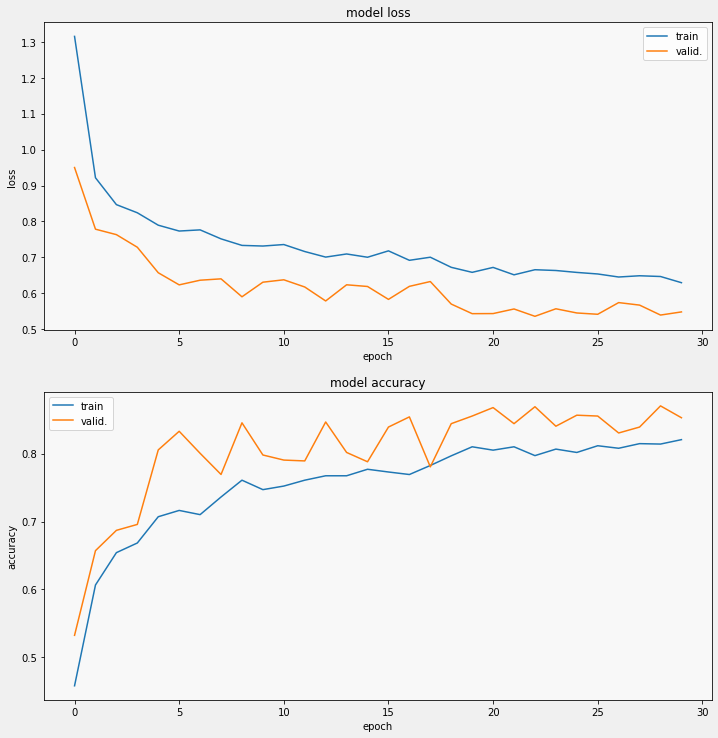

In [53]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

In [54]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

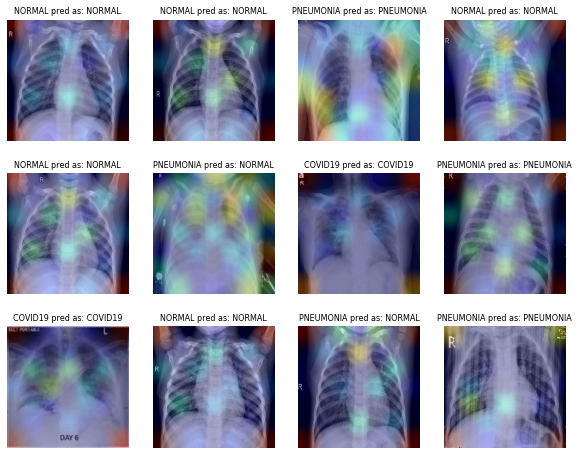

In [55]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_efnet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [56]:
model_efnet.save("model_efnet_30_09169.h5")

# Pretrained VGG

In [57]:
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x3 = pretrained_vgg.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x3)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=categorical_smooth_loss,metrics=['accuracy'])
# model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])
model_vgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [59]:
history_vgg = model_vgg.fit_generator(training_set, validation_data=validation_set, callbacks=[lr_reduce, es_callback], epochs=40) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
51/51 [==============================] - 112s 2s/step - loss: 0.9021 - accuracy: 0.6081 - val_loss: 0.6326 - val_accuracy: 0.8180
Epoch 2/40
51/51 [==============================] - 99s 2s/step - loss: 0.6867 - accuracy: 0.7940 - val_loss: 0.5284 - val_accuracy: 0.8928
Epoch 3/40
51/51 [==============================] - 99s 2s/step - loss: 0.6406 - accuracy: 0.8240 - val_loss: 0.4687 - val_accuracy: 0.9127
Epoch 4/40
51/51 [==============================] - 98s 2s/step - loss: 0.6015 - accuracy: 0.8590 - val_loss: 0.4403 - val_accuracy: 0.9264
Epoch 5/40
51/51 [==============================] - 98s 2s/step - loss: 0.5961 - accuracy: 0.8537 - val_loss: 0.5079 - val_accuracy: 0.8940
Epoch 6/40
51/51 [==============================] - 98s 2s/step - loss: 0.5975 - accuracy: 0.8605 - val_loss: 0.4787 - val_accuracy: 0.9002
Epoch 7/40
51/51 [==============================] - 97s 2s/step - loss: 0.5799 - accuracy: 0.8679 - val_loss: 0.4748 - val_accuracy: 0.9090
Epoch 8/40
51/51 [=

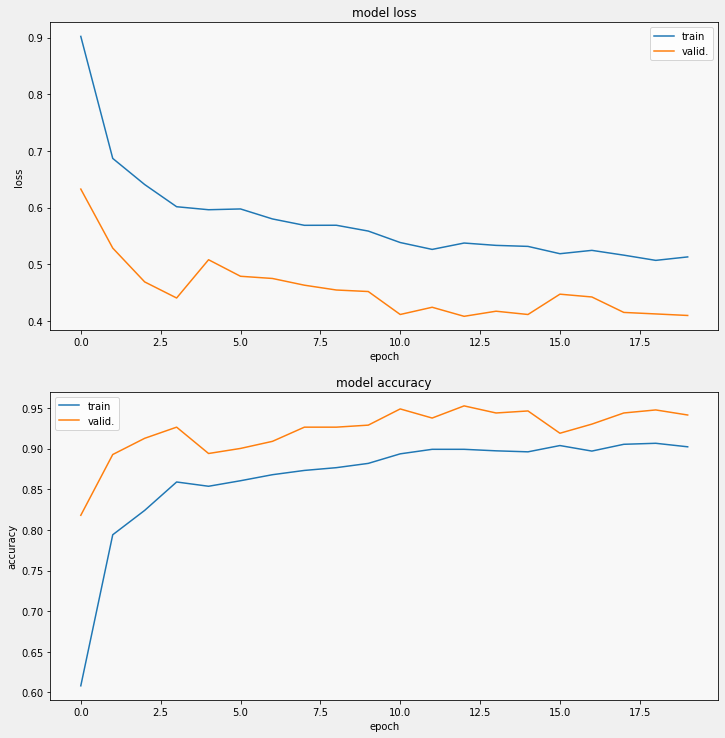

In [60]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [61]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

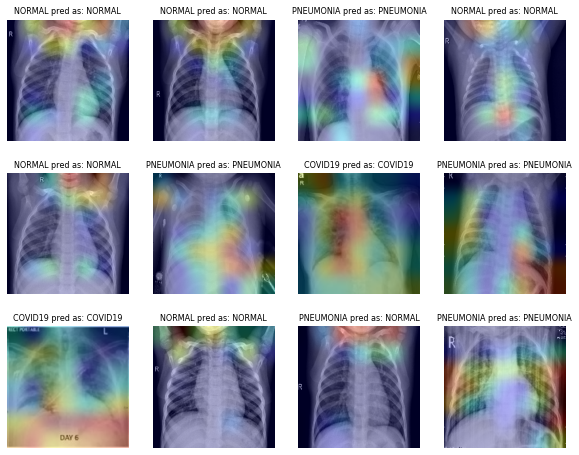

In [62]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_vgg, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [63]:
model_vgg.save("model_vgg_30_09286.h5")

# Ensemble (simply at the last layer)

In [64]:
# model_densenet
# model_efnet
# model_vgg

for layer in model_densenet.layers:
  layer.trainable = False

for layer in model_efnet.layers:
  layer.trainable = False

for layer in model_vgg.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet(visible)
x2 = model_efnet(visible)
x3 = model_vgg(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model_densenet_efnet_vgg.summary()

Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 3)            19428163    input[0][0]                      
__________________________________________________________________________________________________
model_28 (Functional)           (None, 3)            65572499    input[0][0]                      
__________________________________________________________________________________________________
model_53 (Functional)           (None, 3)            15313091    input[0][0]                      
___________________________________________________________________________________________

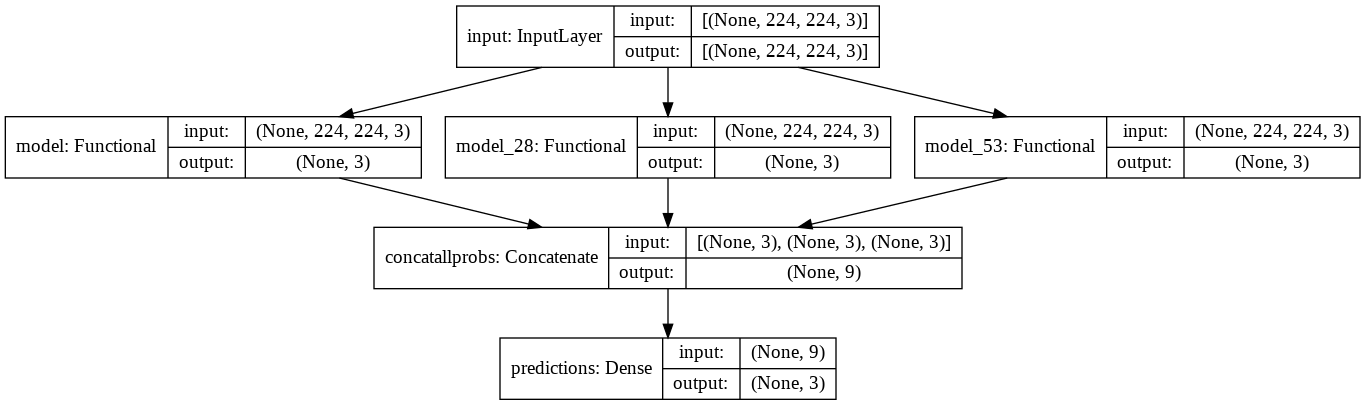

In [65]:
plot_model(model_densenet_efnet_vgg, show_shapes=True, to_file='model_densenet_efnet_vgg.png')

In [66]:
history = model_densenet_efnet_vgg.fit_generator(training_set, validation_data=validation_set, callbacks=[lr_reduce, es_callback], epochs=7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
51/51 [==============================] - 160s 3s/step - loss: 1.5531 - accuracy: 0.1603 - val_loss: 1.5761 - val_accuracy: 0.0586
Epoch 2/7
51/51 [==============================] - 123s 2s/step - loss: 1.5356 - accuracy: 0.1665 - val_loss: 1.5585 - val_accuracy: 0.0698
Epoch 3/7
51/51 [==============================] - 122s 2s/step - loss: 1.5171 - accuracy: 0.1700 - val_loss: 1.5410 - val_accuracy: 0.0761
Epoch 4/7
51/51 [==============================] - 122s 2s/step - loss: 1.4960 - accuracy: 0.1775 - val_loss: 1.5237 - val_accuracy: 0.0898
Epoch 5/7
51/51 [==============================] - 121s 2s/step - loss: 1.5042 - accuracy: 0.1713 - val_loss: 1.5065 - val_accuracy: 0.0998
Epoch 6/7
51/51 [==============================] - 121s 2s/step - loss: 1.4700 - accuracy: 0.1872 - val_loss: 1.4895 - val_accuracy: 0.1234
Epoch 7/7
51/51 [==============================] - 122s 2s/step - loss: 1.4606 - accuracy: 0.1909 - val_loss: 1.4727 - val_accuracy: 0.1347


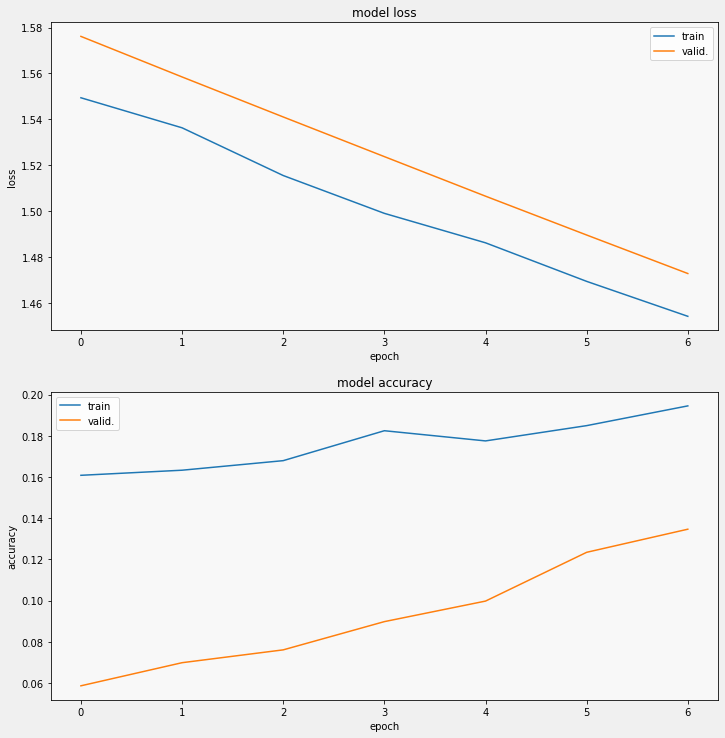

In [67]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [68]:
model_densenet_efnet_vgg.save("model_densenet_efnet_vgg_09581.h5")

# Ensemble: without the heads

In [69]:
#Gives the network the chance to learn from the dense layers before the softmax

# model2= Model(inputs=model1.input, outputs=model1.get_layer(layer_name).output)

model_densenet_nohead = Model(inputs=model_densenet.input, outputs=model_densenet.get_layer("dense_head").output)
model_efnet_nohead = Model(inputs=model_efnet.input, outputs=model_efnet.get_layer("dense_head").output)
model_vgg_nohead = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("dense_head_2").output)

for layer in model_densenet_nohead.layers:
  layer.trainable = False

for layer in model_efnet_nohead.layers:
  layer.trainable = False

for layer in model_vgg_nohead.layers:
  layer.trainable = False

visible = tf.keras.layers.Input(shape=(image_size, image_size, 3), name="input")
x1 = model_densenet_nohead(visible)
x2 = model_efnet_nohead(visible)
x3 = model_vgg_nohead(visible)
merge = tf.keras.layers.concatenate([x1, x2, x3], name="concatallprobs")
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions")(merge)

model_densenet_efnet_vgg_nohead = Model(inputs=visible, outputs=model_out)
model_densenet_efnet_vgg_nohead.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy']) #categorical_smooth_loss
model_densenet_efnet_vgg_nohead.summary()

Model: "model_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_79 (Functional)           (None, 64)           19427968    input[0][0]                      
__________________________________________________________________________________________________
model_80 (Functional)           (None, 64)           65572304    input[0][0]                      
__________________________________________________________________________________________________
model_81 (Functional)           (None, 64)           15312896    input[0][0]                      
___________________________________________________________________________________________

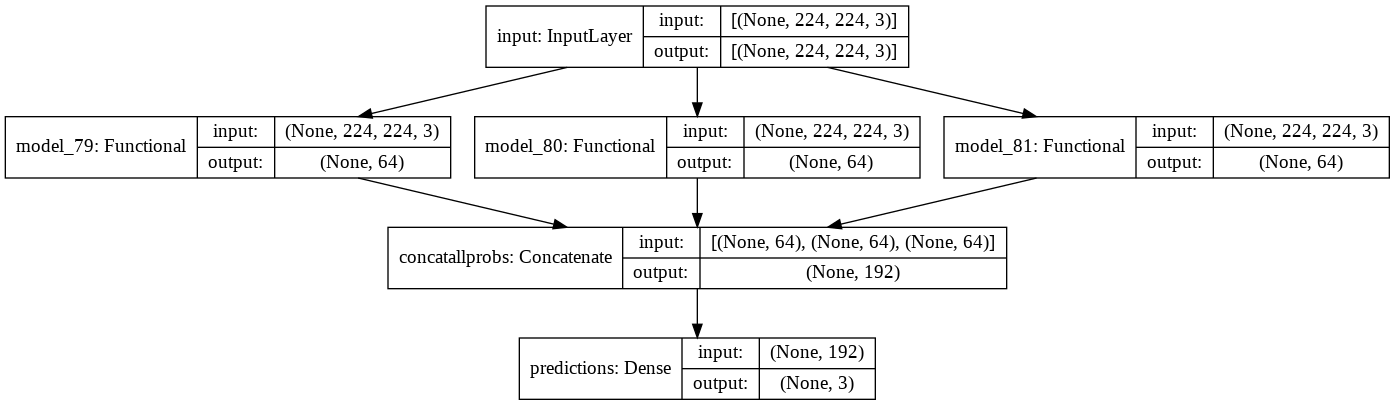

In [70]:
plot_model(model_densenet_efnet_vgg_nohead, show_shapes=True, to_file='model_densenet_efnet_vgg_nohead.png')

In [71]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.001, patience=1, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [72]:
history_nohead = model_densenet_efnet_vgg_nohead.fit_generator(training_set, validation_data=validation_set, callbacks=[lr_reduce, es_callback], epochs=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
51/51 [==============================] - 156s 3s/step - loss: 2.0358 - accuracy: 0.4242 - val_loss: 0.6016 - val_accuracy: 0.8267
Epoch 2/20
51/51 [==============================] - 124s 2s/step - loss: 0.5330 - accuracy: 0.8536 - val_loss: 0.3303 - val_accuracy: 0.8791
Epoch 3/20
51/51 [==============================] - 123s 2s/step - loss: 0.2973 - accuracy: 0.9042 - val_loss: 0.2516 - val_accuracy: 0.9002
Epoch 4/20
51/51 [==============================] - 122s 2s/step - loss: 0.2422 - accuracy: 0.9084 - val_loss: 0.2050 - val_accuracy: 0.9252
Epoch 5/20
51/51 [==============================] - 122s 2s/step - loss: 0.1884 - accuracy: 0.9315 - val_loss: 0.1835 - val_accuracy: 0.9352
Epoch 6/20
51/51 [==============================] - 122s 2s/step - loss: 0.1786 - accuracy: 0.9356 - val_loss: 0.1654 - val_accuracy: 0.9426
Epoch 7/20
51/51 [==============================] - 122s 2s/step - loss: 0.1521 - accuracy: 0.9443 - val_loss: 0.1545 - val_accuracy: 0.9464
Epoch 8/20
51

In [73]:
model_densenet_efnet_vgg_nohead.save("model_densenet_efnet_vgg_nohead_09xxx.h5")

In [103]:

# Evaluating the model on the training and testing set
score = model_densenet.evaluate(training_set, verbose=0)
print("Training Accuracy: ", score[1])

score = model_densenet.evaluate(validation_set, verbose=0)
print("Validation Accuracy: ", score[1])

score = model_densenet.evaluate(testing_set, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9585524201393127
Validation Accuracy:  0.9501246809959412
Testing Accuracy:  0.8092885613441467
